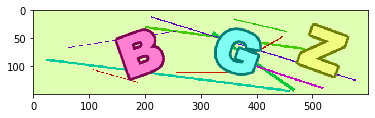

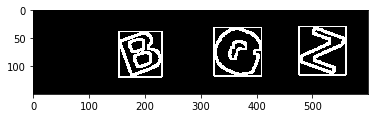

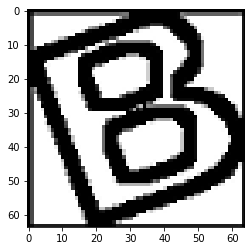

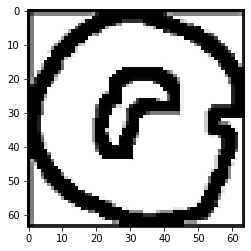

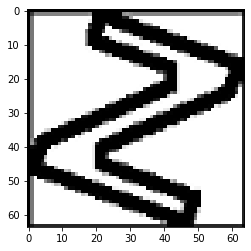

Numbers of letters found = 3


In [257]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


img = cv2.imread('train/BGZ.png')
(rows,cols,ch)=img.shape
masktf=(img==img[0,0].tolist())
masktf=(np.invert(np.all(masktf,axis=2))).astype(np.int)
mask=np.repeat(masktf[:,:,np.newaxis],3,axis=2)
nbimg=np.asarray(img*mask,dtype=np.uint8)
gray = cv2.cvtColor(nbimg, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(gray,kernel,iterations = 3)
ret3,th3 = cv2.threshold(erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th3=cv2.GaussianBlur(th3,(1,1),0)
edges = cv2.Canny(th3,0,0)
edges = cv2.dilate(edges,kernel,iterations = 2)
edges=cv2.GaussianBlur(edges,(1,1),0)
edges=cv2.erode(edges,kernel,iterations = 1)
edged=edges.copy()
_, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
im2=np.zeros(edged.shape,np.uint8)
cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:4]
cnt=list(filter(lambda x: cv2.contourArea(x)>100 , cnt))
plt.figure();
testArr=np.zeros((len(cnt),4),dtype=np.uint)
for i,j in zip(cnt,np.arange(len(cnt))):
    x,y,w,h= cv2.boundingRect(i)
    #print(x,y,w,h)
    testArr[j]=[x,y,w,h]
    #x,y,w,h = cv2.boundingRect(np.array(contours,dtype=np.uint8))
    im3 = cv2.rectangle(edges,(x,y),(x+w,y+h),(255,255,0),2)
    #plt.imshow(im3,cmap="gray"),plt.show()
#     print(cv2.contourArea(i))
testArr=testArr[testArr[:,0].argsort()]
plt.imshow(img),plt.show()
plt.imshow(im3,cmap="gray"),plt.show()
for alp in testArr:
    rx,ry,rw,rh=alp
    #print(rx,ry,rw,rh)
    oneL=edges[ry:(ry+rh),rx:(rx+rw)]
    oneL=np.invert(oneL)
    oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
    plt.imshow(oneL,cmap='gray'),plt.show()
print('Numbers of letters found = ' + str(len(cnt)))



6014.0


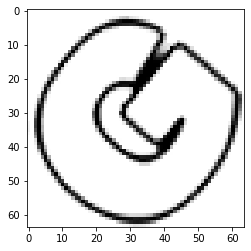

(<matplotlib.image.AxesImage at 0x7fe54d6b5470>, None)

In [99]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('reference/G.png')
(rows,cols,ch)=img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

M = cv2.getRotationMatrix2D((cols/2,rows/2),50,1)
gray = cv2.warpAffine(gray,M,(cols,rows),borderValue=(255,255,255))

edged=np.invert(gray.copy())
_, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:1]
print(cv2.contourArea(cnt[0]))
x,y,w,h= cv2.boundingRect(cnt[0])
oneL=gray[y:(y+h),x:(x+w)]
kernel = np.ones((2,2),np.uint8)
oneL = cv2.dilate(oneL,kernel,iterations = 2)
oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
plt.imshow(oneL,cmap='gray'),plt.show()

In [81]:
import glob
cv_img = []
for i,L in zip(np.arange(26),[chr(i) for i in range(ord('A'),ord('Z')+1)]):
    img='reference/'+L+'.png'
    print(img)
    n= cv2.imread(img)
    cv_img.append(n)
print(cv_img)


reference/A.png
reference/B.png
reference/C.png
reference/D.png
reference/E.png
reference/F.png
reference/G.png
reference/H.png
reference/I.png
reference/J.png
reference/K.png
reference/L.png
reference/M.png
reference/N.png
reference/O.png
reference/P.png
reference/Q.png
reference/R.png
reference/S.png
reference/T.png
reference/U.png
reference/V.png
reference/W.png
reference/X.png
reference/Y.png
reference/Z.png
[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],


In [154]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from collections import deque

def extractHOG(img):
    img=np.float32(img)/255.0
    dix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    diy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(dix, diy, angleInDegrees=True)
    hist=np.zeros((8,8,9))
    for i in np.arange(64):
        for j in np.arange(64):
            hr=np.int32(np.floor(i/8))
            hc=np.int32(np.floor(j/8))
            ang=angle[i,j]%180
            bno=np.int32(np.floor(ang/20))
            nbno=(bno+1)%9
            rem=ang%20;
            w0=(20-rem)/20;
            w1=rem/20;
            hist[hr,hc,bno]+=w0*mag[i,j]
            hist[hr,hc,nbno]+=w1*mag[i,j]
    features=np.zeros((1764,))
    featidx=0
    for i in np.arange(7):
        for j in np.arange(7):
            tmp=np.zeros((36,))
            tmp[0:9]=np.array(hist[i,j,:])
            tmp[9:18]+=hist[i,j+1,:]
            tmp[18:27]+=hist[i+1,j,:]
            tmp[27:36]+=hist[i+1,j+1,:]
            normv=np.linalg.norm(tmp)
            if(normv!=0):
                tmp=tmp/normv
            features[featidx:featidx+36]=tmp;
            featidx+=36
                    
            
            
    return features
    
    


img = cv2.imread('reference/B.png')
(rows,cols,ch)=img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

M = cv2.getRotationMatrix2D((cols/2,rows/2),50,1)
gray = cv2.warpAffine(gray,M,(cols,rows),borderValue=(255,255,255))

edged=np.invert(gray.copy())
_, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:1]
contArea=cv2.contourArea(cnt[0])
x,y,w,h= cv2.boundingRect(cnt[0])
oneL=gray[y:(y+h),x:(x+w)]
kernel = np.ones((2,2),np.uint8)
oneL = cv2.dilate(oneL,kernel,iterations = 2)
oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)




features=extractHOG(oneL)
features=np.hstack((features,[contArea]))
print(features.shape)

(1765,)


In [205]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from collections import deque
import glob

def extractHOG(img):
    img=np.float32(img)/255.0
    dix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    diy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(dix, diy, angleInDegrees=True)
    hist=np.zeros((8,8,9))
    for i in np.arange(64):
        for j in np.arange(64):
            hr=np.int32(np.floor(i/8))
            hc=np.int32(np.floor(j/8))
            ang=angle[i,j]%180
            bno=np.int32(np.floor(ang/20))
            nbno=(bno+1)%9
            rem=ang%20;
            w0=(20-rem)/20;
            w1=rem/20;
            hist[hr,hc,bno]+=w0*mag[i,j]
            hist[hr,hc,nbno]+=w1*mag[i,j]
    features=np.zeros((1764,))
    featidx=0
    for i in np.arange(7):
        for j in np.arange(7):
            tmp=np.zeros((36,))
            tmp[0:9]=np.array(hist[i,j,:])
            tmp[9:18]+=hist[i,j+1,:]
            tmp[18:27]+=hist[i+1,j,:]
            tmp[27:36]+=hist[i+1,j+1,:]
            normv=np.linalg.norm(tmp)
            if(normv!=0):
                tmp=tmp/normv
            features[featidx:featidx+36]=tmp;
            featidx+=36       
    return features



path = glob.glob("temp/*.png")
trainData=[]
for imgname in path:
    alphList=list((imgname.split('/')[1]).split('.')[0]) 
    
    img = cv2.imread(imgname)
    (rows,cols,ch)=img.shape
    masktf=(img==img[0,0].tolist())
    masktf=(np.invert(np.all(masktf,axis=2))).astype(np.int)
    mask=np.repeat(masktf[:,:,np.newaxis],3,axis=2)
    nbimg=np.asarray(img*mask,dtype=np.uint8)
    gray = cv2.cvtColor(nbimg, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(gray,kernel,iterations = 3)
    ret3,th3 = cv2.threshold(erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th3=cv2.GaussianBlur(th3,(1,1),0)
    edges = cv2.Canny(th3,0,0)
    edges = cv2.dilate(edges,kernel,iterations = 2)
    edges=cv2.GaussianBlur(edges,(1,1),0)
    edges=cv2.erode(edges,kernel,iterations = 1)
    edged=edges.copy()
    _, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    im2=np.zeros(edged.shape,np.uint8)
    cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:4]
    cnt=list(filter(lambda x: cv2.contourArea(x)>100 , cnt))
    testArr=np.zeros((len(cnt),4),dtype=np.uint)
    areaArr=np.zeros((len(cnt),),dtype=np.float32)
    for i,j in zip(cnt,np.arange(len(cnt))):
        x,y,w,h= cv2.boundingRect(i)
        testArr[j]=[x,y,w,h]
        areaArr[j]=cv2.contourArea(i)
        im3 = cv2.rectangle(edges,(x,y),(x+w,y+h),(255,255,0),2)
    order=testArr[:,0].argsort()
    testArr=testArr[order]
    areaArr=areaArr[order]
    for alp,arr,ltr in zip(testArr,areaArr,alphList):
        rx,ry,rw,rh=alp
        oneL=edges[ry:(ry+rh),rx:(rx+rw)]
        oneL=np.invert(oneL)
        oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
        feat=extractHOG(oneL)
        tdPoint=np.hstack((feat,[arr],[ord(ltr)-ord('A')]))
        trainData.append(tdPoint)
        
path = glob.glob("temp2/*.png")
features=[]
for imgname in path:
    ltr=ord((imgname.split('/')[1]).split('.')[0])-ord('A')
    ulim=50
    llim=-40
    if (ltr+ord('A'))==ord('Z') or (ltr+ord('A'))==ord('N'):
        ulim=30
        llim=-20
    img = cv2.imread(imgname)
    (rows,cols,ch)=img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for deg in range(llim,ulim,10):
        M = cv2.getRotationMatrix2D((cols/2,rows/2),deg,1)
        gray = cv2.warpAffine(gray,M,(cols,rows),borderValue=(255,255,255))
        edged=np.invert(gray.copy())
        _, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:1]
        contArea=cv2.contourArea(cnt[0])
        x,y,w,h= cv2.boundingRect(cnt[0])
        oneL=gray[y:(y+h),x:(x+w)]
        kernel = np.ones((2,2),np.uint8)
        oneL = cv2.dilate(oneL,kernel,iterations = 2)
        oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
        feat=extractHOG(oneL)
        tdPoint=np.hstack((feat,[contArea],[ltr]))
        trainData.append(tdPoint)
print(np.array(trainData).shape)
np.savetxt('data.out', np.array(trainData), delimiter=',') 

(42, 1766)


In [225]:
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
print(X.shape)

(100, 4)


[66]


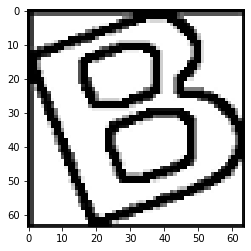

[71]


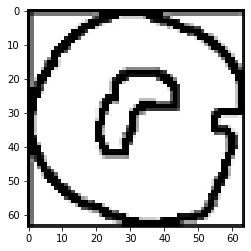

[90]


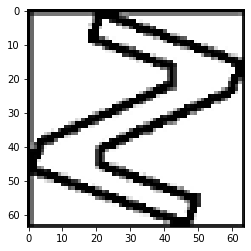

[66]


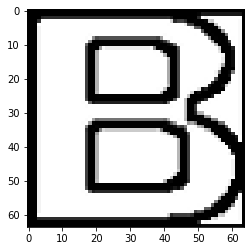

[72]


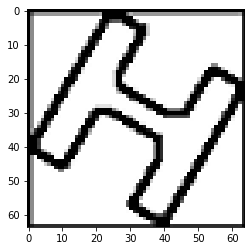

[65]


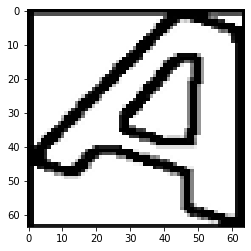

[69]


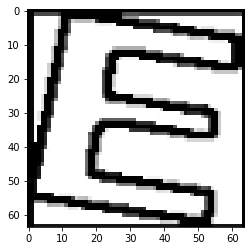

(array([3, 4]), ['BGZ', 'BHAE'])


In [331]:
import numpy as np
from sklearn.svm import LinearSVC
import pickle 
import cv2
from matplotlib import pyplot as plt
import glob


def extractHOG(img):
    img=np.float32(img)/255.0
    dix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    diy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(dix, diy, angleInDegrees=True)
    hist=np.zeros((8,8,9))
    for i in np.arange(64):
        for j in np.arange(64):
            hr=np.int32(np.floor(i/8))
            hc=np.int32(np.floor(j/8))
            ang=angle[i,j]%180
            bno=np.int32(np.floor(ang/20))
            nbno=(bno+1)%9
            rem=ang%20;
            w0=(20-rem)/20;
            w1=rem/20;
            hist[hr,hc,bno]+=w0*mag[i,j]
            hist[hr,hc,nbno]+=w1*mag[i,j]
    features=np.zeros((1764,))
    featidx=0
    for i in np.arange(7):
        for j in np.arange(7):
            tmp=np.zeros((36,))
            tmp[0:9]=np.array(hist[i,j,:])
            tmp[9:18]+=hist[i,j+1,:]
            tmp[18:27]+=hist[i+1,j,:]
            tmp[27:36]+=hist[i+1,j+1,:]
            normv=np.linalg.norm(tmp)
            if(normv!=0):
                tmp=tmp/normv
            features[featidx:featidx+36]=tmp;
            featidx+=36       
    return features



def decaptcha( filenames ):
    clf = pickle.load(open('final_submit/model_rf_26', 'rb'))
    numChars=[]
    codes=[]
    for imgname in filenames:
        img = cv2.imread(imgname)
        (rows,cols,ch)=img.shape
        masktf=(img==img[0,0].tolist())
        masktf=(np.invert(np.all(masktf,axis=2))).astype(np.int)
        mask=np.repeat(masktf[:,:,np.newaxis],3,axis=2)
        nbimg=np.asarray(img*mask,dtype=np.uint8)
        gray = cv2.cvtColor(nbimg, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.erode(gray,kernel,iterations = 3)
        ret3,th3 = cv2.threshold(erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        th3=cv2.GaussianBlur(th3,(1,1),0)
        edges = cv2.Canny(th3,0,0)
        edges = cv2.dilate(edges,kernel,iterations = 2)
        edges=cv2.GaussianBlur(edges,(1,1),0)
        edges=cv2.erode(edges,kernel,iterations = 1)
        edged=edges.copy()
        _, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        im2=np.zeros(edged.shape,np.uint8)
        cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:4]
        cnt=list(filter(lambda x: cv2.contourArea(x)>100 , cnt))
        testArr=np.zeros((len(cnt),4),dtype=np.uint)
        areaArr=np.zeros((len(cnt),),dtype=np.float32)
        for i,j in zip(cnt,np.arange(len(cnt))):
            x,y,w,h= cv2.boundingRect(i)
            testArr[j]=[x,y,w,h]
            areaArr[j]=cv2.contourArea(i)
            im3 = cv2.rectangle(edges,(x,y),(x+w,y+h),(255,255,0),2)
        order=testArr[:,0].argsort()
        testArr=testArr[order]
        areaArr=areaArr[order]
        alphs=[]
        for alp,arr in zip(testArr,areaArr):
            rx,ry,rw,rh=alp
            oneL=edges[ry:(ry+rh),rx:(rx+rw)]
            oneL=np.invert(oneL)
            oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
            feat=extractHOG(oneL)
            tdPoint=np.array(np.hstack((feat,[arr])))
            ch=clf.predict([tdPoint])
            ch=ch+ord('A')
            print(ch)
            plt.imshow(oneL,cmap='gray'),plt.show()
            alphs.append(chr(ch))
        numChars.append(len(cnt))
        code=''.join(alphs)
        codes.append(code)
    numChars=np.array(numChars)
    return (numChars, codes)

filenames=list(['test/image1.png','test/image2.png'])
print(decaptcha(filenames))

In [258]:
import numpy as np
from sklearn.svm import LinearSVC
import pickle 

data=np.genfromtxt('trial.out',delimiter=',', dtype= np.float32)
X=data[:,:-1]
Y=np.int32(data[:,-1])
clf = LinearSVC(random_state=0)
clf.fit(X,Y)

filename = 'model'
pickle.dump(clf, open(filename, 'wb'))



/home/codinion/.conda/envs/dataPy/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ValueError: not enough values to unpack (expected 3, got 2)

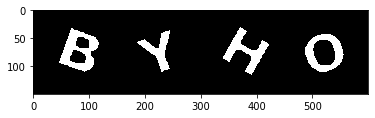

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


img = cv2.imread('train/BYHO.png')
(rows,cols,ch)=img.shape
masktf=(img==img[0,0].tolist())
masktf=(np.invert(np.all(masktf,axis=2))).astype(np.int)
mask=np.repeat(masktf[:,:,np.newaxis],3,axis=2)
nbimg=np.asarray(img*mask,dtype=np.uint8)
gray = cv2.cvtColor(nbimg, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(gray,kernel,iterations = 3)
ret3,th3 = cv2.threshold(erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th3,cmap="gray")
th3=cv2.GaussianBlur(th3,(3,3),0)
edges = cv2.Canny(th3,0,0)
edges = cv2.dilate(edges,kernel,iterations = 2)
edges=cv2.GaussianBlur(edges,(1,1),0)
edges=cv2.erode(edges,kernel,iterations = 1)
edged=edges.copy()
contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
im2=np.zeros(edged.shape,np.uint8)
cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:4]
cnt=list(filter(lambda x: cv2.contourArea(x)>1000 , cnt))
plt.figure();
testArr=np.zeros((len(cnt),4),dtype=np.uint)
for i,j in zip(cnt,np.arange(len(cnt))):
    x,y,w,h= cv2.boundingRect(i)
    #print(x,y,w,h)
    testArr[j]=[x,y,w,h]
    #x,y,w,h = cv2.boundingRect(np.array(contours,dtype=np.uint8))
    im3 = cv2.rectangle(edges,(x,y),(x+w,y+h),(255,255,0),2)
    #plt.imshow(im3,cmap="gray"),plt.show()
#     print(cv2.contourArea(i))
testArr=testArr[testArr[:,0].argsort()]
plt.imshow(img),plt.show()
plt.imshow(im3,cmap="gray"),plt.show()



image = cv2.imread("test.jpg",0)
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
#compute(img[, winStride[, padding[, locations]]]) -> descriptors
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)

histo=[]
for alp in testArr:
    rx,ry,rw,rh=alp
    #print(rx,ry,rw,rh)
    oneL=edges[ry:(ry+rh),rx:(rx+rw)]
    oneL=np.invert(oneL)
    oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
    hist = hog.compute(image,winStride,padding,locations)
    histo.append(hist)
    plt.imshow(oneL,cmap='gray'),plt.show()
print('Numbers of letters found = ' + str(len(cnt)))



500446


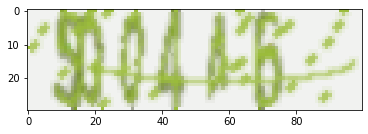

In [268]:
from captcha.image import ImageCaptcha  # pip install captcha
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

number = ['0','1','2','3','4','5','6','7','8','9']
MAX_CAPTCHA = 6
WIDTH=100
HEIGHT=30

image = ImageCaptcha(width=WIDTH, height=HEIGHT, font_sizes=[30])

captcha_text = []
for i in range(MAX_CAPTCHA):
    c = random.choice(number)
    captcha_text.append(c)
    #print(captcha_text)
captcha_text = ''.join(captcha_text)
print(captcha_text)

captcha = image.generate(captcha_text)
captcha_image = Image.open(captcha)
captcha_image = np.array(captcha_image)

#image.write(captcha_text, str(i)+'_'+captcha_text + '.png') 
plt.imshow(captcha_image)
plt.show()  

In [319]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from collections import deque
import glob

path = glob.glob("train/*.png")
i=0
codefile=open("mytests/codes.txt",'w')
for imgname in path:
    img=cv2.imread(imgname)
    newpath='mytests/image%d'%i+'.png'
    i+=1
    cv2.imwrite(newpath,img)
    codefile.write(((imgname.split('/'))[1]).split('.')[0] + '\n')
codefile.close()

In [324]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import pickle 

data=np.genfromtxt('data.out',delimiter=',', dtype= np.float32)
X=data[:,:-1]
Y=np.int32(data[:,-1])
clf = RandomForestClassifier(n_estimators=10, max_depth=4,random_state=0)
clf.fit(X,Y)

filename = 'model_rf'
pickle.dump(clf, open(filename, 'wb'))

In [335]:
from skimage.feature import hog
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from collections import deque
import glob




path = glob.glob("train/*.png")
trainData=[]
for imgname in path:
    alphList=list((imgname.split('/')[1]).split('.')[0]) 
    
    img = cv2.imread(imgname)
    (rows,cols,ch)=img.shape
    masktf=(img==img[0,0].tolist())
    masktf=(np.invert(np.all(masktf,axis=2))).astype(np.int)
    mask=np.repeat(masktf[:,:,np.newaxis],3,axis=2)
    nbimg=np.asarray(img*mask,dtype=np.uint8)
    gray = cv2.cvtColor(nbimg, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(gray,kernel,iterations = 3)
    ret3,th3 = cv2.threshold(erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th3=cv2.GaussianBlur(th3,(1,1),0)
    edges = cv2.Canny(th3,0,0)
    edges = cv2.dilate(edges,kernel,iterations = 2)
    edges=cv2.GaussianBlur(edges,(1,1),0)
    edges=cv2.erode(edges,kernel,iterations = 1)
    edged=edges.copy()
    _, contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    im2=np.zeros(edged.shape,np.uint8)
    cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:4]
    cnt=list(filter(lambda x: cv2.contourArea(x)>1000 , cnt))
    testArr=np.zeros((len(cnt),4),dtype=np.uint)
    areaArr=np.zeros((len(cnt),),dtype=np.float32)
    for i,j in zip(cnt,np.arange(len(cnt))):
        x,y,w,h= cv2.boundingRect(i)
        testArr[j]=[x,y,w,h]
        areaArr[j]=cv2.contourArea(i)
    order=testArr[:,0].argsort()
    testArr=testArr[order]
    areaArr=areaArr[order]
    for alp,arr,ltr in zip(testArr,areaArr,alphList):
        rx,ry,rw,rh=alp
        oneL=edges[ry:(ry+rh),rx:(rx+rw)]
        oneL=np.invert(oneL)
        oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
        feat, _ = hog(oneL, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
        tdPoint=np.hstack((feat,[arr],[ord(ltr)-ord('A')]))
        trainData.append(tdPoint)
        
path = glob.glob("reference/*.png")
features=[]
for imgname in path:
    ltr=ord((imgname.split('/')[1]).split('.')[0])-ord('A')
    ulim=50
    llim=-40
    if (ltr+ord('A'))==ord('Z') or (ltr+ord('A'))==ord('N'):
        ulim=30
        llim=-20
    img = cv2.imread(imgname)
    (rows,cols,ch)=img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for deg in range(llim,ulim,10):
        M = cv2.getRotationMatrix2D((cols/2,rows/2),deg,1)
        gray = cv2.warpAffine(gray,M,(cols,rows),borderValue=(255,255,255))
        edged=np.invert(gray.copy())
        contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:1]
        contArea=cv2.contourArea(cnt[0])
        x,y,w,h= cv2.boundingRect(cnt[0])
        oneL=gray[y:(y+h),x:(x+w)]
        kernel = np.ones((2,2),np.uint8)
        oneL = cv2.dilate(oneL,kernel,iterations = 2)
        oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
        #feat=extractHOG(oneL)
        feat, hog_image = hog(oneL, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
        tdPoint=np.hstack((feat,[contArea],[ltr]))
        trainData.append(tdPoint)
        
np.savetxt('data_hog.out', np.array(trainData), delimiter=',')

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import pickle 
import cv2
from matplotlib import pyplot as plt
import glob
from skimage.feature import hog


def decaptcha( filenames ):
    clf = pickle.load(open('submit_try_3/model_rf_10_none', 'rb'))
    numChars=[]
    codes=[]
    cv_img=[]
    for imgname in filenames:
        img = cv2.imread(imgname)
        cv_img.append(img)
    for img in cv_img:
        (rows,cols,ch)=img.shape
        masktf=(img==img[0,0].tolist())
        masktf=(np.invert(np.all(masktf,axis=2))).astype(np.int)
        mask=np.repeat(masktf[:,:,np.newaxis],3,axis=2)
        nbimg=np.asarray(img*mask,dtype=np.uint8)
        gray = cv2.cvtColor(nbimg, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3,3),np.uint8)
        erosion = cv2.erode(gray,kernel,iterations = 3)
        ret3,th3 = cv2.threshold(erosion,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        th3=cv2.GaussianBlur(th3,(1,1),0)
        edges = cv2.Canny(th3,0,0)
        edges = cv2.dilate(edges,kernel,iterations = 2)
        edges=cv2.GaussianBlur(edges,(1,1),0)
        edges=cv2.erode(edges,kernel,iterations = 1)
        edged=edges.copy()
        contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        im2=np.zeros(edged.shape,np.uint8)
        cnt=sorted(contours,key=cv2.contourArea,reverse=True)[:4]
        cnt=list(filter(lambda x: cv2.contourArea(x)>1000 , cnt))
        testArr=np.zeros((len(cnt),4),dtype=np.uint)
        areaArr=np.zeros((len(cnt),),dtype=np.float32)
        for i,j in zip(cnt,np.arange(len(cnt))):
            x,y,w,h= cv2.boundingRect(i)
            testArr[j]=[x,y,w,h]
            areaArr[j]=cv2.contourArea(i)
            im3 = cv2.rectangle(edges,(x,y),(x+w,y+h),(255,255,0),2)
        order=testArr[:,0].argsort()
        testArr=testArr[order]
        areaArr=areaArr[order]
        alphs=[]
        codeList=[]
        for alp,arr in zip(testArr,areaArr):
            rx,ry,rw,rh=alp
            oneL=edges[ry:(ry+rh),rx:(rx+rw)]
            oneL=np.invert(oneL)
            oneL = cv2.resize(oneL,(64,64), interpolation = cv2.INTER_CUBIC)
            feat, _ = hog(oneL, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
            codeList.append(np.array(np.hstack((feat,[arr]))))
            ch=clf.predict(codeList)
        numChars.append(len(cnt))
        ch[:]+=ord('A')
        ch=[chr(ch[i]) for i in np.arange(len(ch))]
        code=''.join(ch)
        codes.append(code)
    numChars=np.array(numChars)
    return (numChars, codes)

filenames=list(['test/image1.png','test/image2.png'])
print(decaptcha(filenames))

(array([3, 4]), ['BGZ', 'BHAE'])
